# EDA for Listings Dataset

**Goal:** Investigate the dataset's quality and identify issues to build a robust Spark ingestion pipeline.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

In [2]:
DATASET_PATH = "../listings/listings.jsonl"

### 1. Load Raw Data
Load the dataset from the JSONL file without any type conversions to inspect its initial state.
We prefer to use JSONL over CSV because it is more structured and safer to use especially with the description column (multiline and contains csv format special caracters)


In [6]:
df_raw = pd.read_json(DATASET_PATH, lines=True)
df_raw.head()

,listing_id,transaction_type,item_type,item_subtype,start_date,change_date,price,area,site_area,floor,...,has_garden,city,zipcode,has_passenger_lift,is_new_construction,build_year,terrace_area,has_cellar,is_furnished,description_fr
0,154794171,TRANSACTION_TYPE.SELL,ITEM_TYPE.HOUSE,ITEM_TYPE.HOUSE.SINGLE_FAMILY_HOUSE,1577836800000,1577836800000,326000.0,118.0,1700.0,NaN,...,NaN,Boisset-les-Montrond,42210,NaN,False,2004.0,NaN,0.0,0.0,"BOISSET-LES-MONTROND (42210), proche A 72, en ..."
1,154794173,TRANSACTION_TYPE.SELL,ITEM_TYPE.HOUSE,ITEM_TYPE.HOUSE.TOWN_HOUSE,1577836800000,1577836800000,127600.0,106.0,NaN,NaN,...,NaN,Feurs,42110,NaN,False,1949.0,NaN,0.0,0.0,"FEURS (42110), proche toutes commodités, entre..."
2,154794175,TRANSACTION_TYPE.SELL,ITEM_TYPE.HOUSE,ITEM_TYPE.HOUSE.SINGLE_FAMILY_HOUSE,1577836800000,1577836800000,216000.0,100.0,1000.0,NaN,...,NaN,Feurs,42110,NaN,False,2008.0,NaN,0.0,0.0,FEURS 42210 (proche centre ville)\r\nParlez Mo...
3,154794177,TRANSACTION_TYPE.SELL,ITEM_TYPE.HOUSE,ITEM_TYPE.HOUSE.EXCEPTIONAL_PROPERTY,1577836800000,1577836800000,182000.0,100.0,871.0,NaN,...,NaN,Feurs,42110,NaN,False,1969.0,NaN,0.0,0.0,"FEURS (42110) proche centre ville, je vous pro..."
4,154794179,TRANSACTION_TYPE.SELL,ITEM_TYPE.HOUSE,ITEM_TYPE.HOUSE.TOWN_HOUSE,1577836800000,1577836800000,142000.0,125.0,NaN,NaN,...,NaN,Magneux-Haute-Rive,42600,NaN,False,1900.0,NaN,0.0,0.0,MAGNEUX HAUTE RIVE (42600) Installez-vous en t...


In [7]:
df_raw.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 23 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   listing_id           100000 non-null  int64  
 1   transaction_type     100000 non-null  object 
 2   item_type            100000 non-null  object 
 3   item_subtype         99952 non-null   object 
 4   start_date           100000 non-null  int64  
 5   change_date          100000 non-null  int64  
 6   price                100000 non-null  float64
 7   area                 98847 non-null   float64
 8   site_area            54193 non-null   float64
 9   floor                34121 non-null   float64
 10  room_count           99220 non-null   float64
 11  balcony_count        38249 non-null   float64
 12  terrace_count        23764 non-null   float64
 13  has_garden           200 non-null     float64
 14  city                 100000 non-null  object 
 15  zipcode           

In [8]:
df_raw.describe()

,listing_id,start_date,change_date,price,area,site_area,floor,room_count,balcony_count,terrace_count,has_garden,zipcode,has_passenger_lift,build_year,terrace_area,has_cellar,is_furnished
count,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,98847.000000,5.419300e+04,34121.000000,99220.000000,38249.000000,23764.000000,200.000000,100000.000000,29078.000000,2.501600e+04,77.000000,46383.000000,55926.000000
mean,1.549065e+08,1.578133e+12,1.578338e+12,1.808113e+05,87.854017,1.008344e+03,2.526509,3.966368,0.372062,0.981569,0.100000,52869.211770,0.577756,2.751166e+03,30.814286,0.342000,0.119336
std,8.155213e+05,1.675729e+08,3.226634e+08,1.683095e+05,81.960837,9.678552e+03,60.178411,1.737883,0.610944,14.268542,0.300753,28063.586625,0.493925,1.239221e+05,26.638989,0.474385,0.324187
min,1.547942e+08,1.577837e+12,1.577837e+12,0.000000e+00,6.300000,9.200000e-01,-10.000000,1.000000,0.000000,0.000000,0.000000,75.000000,0.000000,1.000000e+00,0.000000,0.000000,0.000000
25%,1.548358e+08,1.577999e+12,1.578079e+12,1.150000e+03,60.000000,3.950000e+02,1.000000,3.000000,0.000000,0.000000,0.000000,31200.000000,0.000000,1.948000e+03,7.300000,0.000000,0.000000
50%,1.548823e+08,1.578107e+12,1.578321e+12,1.806860e+05,87.000000,5.370000e+02,2.000000,4.000000,0.000000,1.000000,0.000000,49360.000000,1.000000,1.977000e+03,23.000000,0.000000,0.000000
75%,1.549299e+08,1.578322e+12,1.578544e+12,2.689000e+05,105.000000,8.130000e+02,3.000000,5.000000,1.000000,1.000000,0.000000,77840.000000,1.000000,2.006000e+03,57.700001,1.000000,0.000000
max,1.909007e+08,1.578404e+12,1.579264e+12,4.750000e+06,20000.000000,1.150000e+06,11111.000000,65.000000,30.000000,1260.000000,1.000000,99000.000000,1.000000,1.960197e+07,91.500000,1.000000,1.000000


### 2. Data Type Conversion
The raw data has many columns loaded as floats that should be integers or booleans. We should check which columns can be safely converted.


In [9]:
int_cols = ["floor", "room_count", "balcony_count", "terrace_count", "build_year"]
for col in int_cols:
    if np.all(df_raw[col].dropna().unique() % 1 == 0):
        print(f"can cast column '{col}' to int")
    else:
        print(f"cannot cast column '{col}' to int, information loss risk")
        print(df_raw[col].unique())

can cast column 'floor' to int
can cast column 'room_count' to int
can cast column 'balcony_count' to int
can cast column 'terrace_count' to int
can cast column 'build_year' to int


In [10]:
bool_cols = [
    "has_garden",
    "has_passenger_lift",
    "is_new_construction",
    "has_cellar",
    "is_furnished",
]
for col in bool_cols:
    if len(df_raw[col].dropna().unique()) <= 2:
        print(f"can cast column '{col}' to bool")
    else:
        print(f"cannot cast column '{col}' to bool")
        print(df_raw[col].unique())

can cast column 'has_garden' to bool
can cast column 'has_passenger_lift' to bool
can cast column 'is_new_construction' to bool
can cast column 'has_cellar' to bool
can cast column 'is_furnished' to bool


In [11]:
df_raw[df_raw["is_furnished"].astype(bool).isnull()]

,listing_id,transaction_type,item_type,item_subtype,start_date,change_date,price,area,site_area,floor,...,has_garden,city,zipcode,has_passenger_lift,is_new_construction,build_year,terrace_area,has_cellar,is_furnished,description_fr


**Finding:** The boolean-like columns contain `NaN` values, so they should be cast to a nullable boolean type.


In [12]:
df_raw[df_raw["is_furnished"].isnull()]

,listing_id,transaction_type,item_type,item_subtype,start_date,change_date,price,area,site_area,floor,...,has_garden,city,zipcode,has_passenger_lift,is_new_construction,build_year,terrace_area,has_cellar,is_furnished,description_fr
6,154794183,TRANSACTION_TYPE.SELL,ITEM_TYPE.HOUSE,ITEM_TYPE.HOUSE.EXCEPTIONAL_PROPERTY,1577836920000,1577836920000,131440.0,81.0,900.0,NaN,...,NaN,Le Grand-Bourg,23240,NaN,False,2015.0,NaN,NaN,NaN,Remarquable habitation moderne de 2015 (Garant...
10,154794187,TRANSACTION_TYPE.SELL,ITEM_TYPE.HOUSE,ITEM_TYPE.HOUSE.SINGLE_FAMILY_HOUSE,1577836980000,1577836980000,199500.0,110.0,890.0,NaN,...,NaN,Juilley,50220,NaN,False,NaN,NaN,1.0,NaN,"Très belle maison de plain pied de 100 m², tou..."
11,154794189,TRANSACTION_TYPE.SELL,ITEM_TYPE.APARTMENT,ITEM_TYPE.APARTMENT.DUPLEX_OR_TRIPLEX,1577837040000,1577837040000,280000.0,127.0,NaN,0.0,...,NaN,Saint-Symphorien-d'Ozon,69360,NaN,False,NaN,NaN,1.0,NaN,Élodie & Maxime MAUGÉ vous proposent en exclus...
12,154794191,TRANSACTION_TYPE.SELL,ITEM_TYPE.HOUSE,ITEM_TYPE.HOUSE.TOWN_HOUSE,1577837040000,1577837040000,299000.0,127.0,170.0,NaN,...,NaN,Communay,69360,NaN,False,NaN,NaN,1.0,NaN,Maugé Immobilier - En exclusivité\r\nEn plein ...
13,154794193,TRANSACTION_TYPE.SELL,ITEM_TYPE.HOUSE,ITEM_TYPE.HOUSE.EXCEPTIONAL_PROPERTY,1577837040000,1577837040000,189000.0,84.0,742.0,NaN,...,NaN,Anet,28260,NaN,False,NaN,NaN,NaN,NaN,"Maison de 85 m² proche du centre ville d'Anet,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,190900607,TRANSACTION_TYPE.SELL,ITEM_TYPE.APARTMENT,ITEM_TYPE.APARTMENT.APARTMENT,1577880240000,1577880240000,265000.0,46.0,NaN,NaN,...,NaN,Colombes,92700,NaN,False,NaN,NaN,NaN,NaN,Colombes quartier Olympique à proximité de la ...
99996,190900607,TRANSACTION_TYPE.SELL,ITEM_TYPE.APARTMENT,ITEM_TYPE.APARTMENT.APARTMENT,1577880240000,1578703376000,265000.0,46.0,NaN,NaN,...,NaN,Colombes,92700,NaN,False,NaN,NaN,NaN,NaN,Colombes quartier Olympique à proximité de la ...
99997,190900637,TRANSACTION_TYPE.SELL,ITEM_TYPE.APARTMENT,ITEM_TYPE.APARTMENT.APARTMENT,1577880240000,1577880240000,285000.0,45.0,NaN,NaN,...,NaN,Colombes,92700,NaN,False,NaN,NaN,NaN,NaN,Colombes quartier Olympique à proximité de la ...
99998,190900715,TRANSACTION_TYPE.SELL,ITEM_TYPE.APARTMENT,ITEM_TYPE.APARTMENT.APARTMENT,1577880240000,1577880240000,325000.0,64.0,NaN,NaN,...,NaN,Colombes,92700,NaN,False,NaN,NaN,NaN,NaN,Colombes quartier Olympique à proximité de la ...


### 3. Load Data with Correct Types
Reload the dataframe using a predefined `dtype_dict` to cast columns to their appropriate types, including nullable integers (`Int64`) and booleans (`boolean`). This reduces memory usage and makes data handling safer.


In [13]:
dtype_dict = {
    "listing_id": "int64",
    "transaction_type": "category",
    "item_type": "category",
    "item_subtype": "category",
    "price": "float64",
    "area": "float64",
    "site_area": "float64",
    "floor": "Int64",
    "room_count": "Int64",  # nullable int
    "balcony_count": "Int64",
    "terrace_count": "Int64",
    "has_garden": "boolean",  # nullable bool
    "city": "string",
    "zipcode": "string",
    "has_passenger_lift": "boolean",
    "is_new_construction": "boolean",
    "build_year": "Int64",
    "terrace_area": "float64",
    "has_cellar": "boolean",
    "is_furnished": "boolean",
    "description_fr": "string",
}

df = pd.read_json(
    DATASET_PATH,
    lines=True,
    dtype=dtype_dict,
    convert_dates=["start_date", "change_date"],
)

df.head()

,listing_id,transaction_type,item_type,item_subtype,start_date,change_date,price,area,site_area,floor,...,has_garden,city,zipcode,has_passenger_lift,is_new_construction,build_year,terrace_area,has_cellar,is_furnished,description_fr
0,154794171,TRANSACTION_TYPE.SELL,ITEM_TYPE.HOUSE,ITEM_TYPE.HOUSE.SINGLE_FAMILY_HOUSE,2020-01-01,2020-01-01,326000.0,118.0,1700.0,<NA>,...,<NA>,Boisset-les-Montrond,42210,<NA>,False,2004,NaN,False,False,"BOISSET-LES-MONTROND (42210), proche A 72, en ..."
1,154794173,TRANSACTION_TYPE.SELL,ITEM_TYPE.HOUSE,ITEM_TYPE.HOUSE.TOWN_HOUSE,2020-01-01,2020-01-01,127600.0,106.0,NaN,<NA>,...,<NA>,Feurs,42110,<NA>,False,1949,NaN,False,False,"FEURS (42110), proche toutes commodités, entre..."
2,154794175,TRANSACTION_TYPE.SELL,ITEM_TYPE.HOUSE,ITEM_TYPE.HOUSE.SINGLE_FAMILY_HOUSE,2020-01-01,2020-01-01,216000.0,100.0,1000.0,<NA>,...,<NA>,Feurs,42110,<NA>,False,2008,NaN,False,False,FEURS 42210 (proche centre ville)\r\nParlez Mo...
3,154794177,TRANSACTION_TYPE.SELL,ITEM_TYPE.HOUSE,ITEM_TYPE.HOUSE.EXCEPTIONAL_PROPERTY,2020-01-01,2020-01-01,182000.0,100.0,871.0,<NA>,...,<NA>,Feurs,42110,<NA>,False,1969,NaN,False,False,"FEURS (42110) proche centre ville, je vous pro..."
4,154794179,TRANSACTION_TYPE.SELL,ITEM_TYPE.HOUSE,ITEM_TYPE.HOUSE.TOWN_HOUSE,2020-01-01,2020-01-01,142000.0,125.0,NaN,<NA>,...,<NA>,Magneux-Haute-Rive,42600,<NA>,False,1900,NaN,False,False,MAGNEUX HAUTE RIVE (42600) Installez-vous en t...


In [14]:
df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 23 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   listing_id           100000 non-null  int64         
 1   transaction_type     100000 non-null  category      
 2   item_type            100000 non-null  category      
 3   item_subtype         99952 non-null   category      
 4   start_date           100000 non-null  datetime64[ns]
 5   change_date          100000 non-null  datetime64[ns]
 6   price                100000 non-null  float64       
 7   area                 98847 non-null   float64       
 8   site_area            54193 non-null   float64       
 9   floor                34121 non-null   Int64         
 10  room_count           99220 non-null   Int64         
 11  balcony_count        38249 non-null   Int64         
 12  terrace_count        23764 non-null   Int64         
 13  has_garden     

### 4. Data Exploration and Cleaning


In [15]:
df.describe()

,listing_id,start_date,change_date,price,area,site_area,floor,room_count,balcony_count,terrace_count,build_year,terrace_area
count,1.000000e+05,100000,100000,1.000000e+05,98847.000000,5.419300e+04,34121.0,99220.0,38249.0,23764.0,25016.0,77.000000
mean,1.549065e+08,2020-01-04 10:13:48.314400256,2020-01-06 19:08:40.424789760,1.808113e+05,87.854017,1.008344e+03,2.526509,3.966368,0.372062,0.981569,2751.166413,30.814286
min,1.547942e+08,2020-01-01 00:00:00,2020-01-01 00:00:00,0.000000e+00,6.300000,9.200000e-01,-10.0,1.0,0.0,0.0,1.0,0.000000
25%,1.548358e+08,2020-01-02 21:02:00,2020-01-03 19:21:00,1.150000e+03,60.000000,3.950000e+02,1.0,3.0,0.0,0.0,1948.0,7.300000
50%,1.548823e+08,2020-01-04 03:09:00,2020-01-06 14:36:26.500000,1.806860e+05,87.000000,5.370000e+02,2.0,4.0,0.0,1.0,1977.0,23.000000
75%,1.549299e+08,2020-01-06 14:46:00,2020-01-09 04:29:27.249999872,2.689000e+05,105.000000,8.130000e+02,3.0,5.0,1.0,1.0,2006.0,57.700001
max,1.909007e+08,2020-01-07 13:33:00,2020-01-17 12:33:23,4.750000e+06,20000.000000,1.150000e+06,11111.0,65.0,30.0,1260.0,19601970.0,91.500000
std,8.155213e+05,NaN,NaN,1.683095e+05,81.960837,9.678552e+03,60.178411,1.737883,0.610944,14.268542,123922.113424,26.638989


#### 4.1 Zipcode Cleaning
Zipcodes have varying lengths (dataset includes zipcodes from different contries so different formats).

In [ ]:
df["zipcode"].str.len().describe()

count    100000.0
mean      4.99797
std      0.073661
min           2.0
25%           5.0
50%           5.0
75%           5.0
max           5.0
Name: zipcode, dtype: Float64

In [16]:
df["zipcode"].str.len().value_counts()

zipcode
5    99911
2       56
4       31
3        2
Name: count, dtype: Int64

In [17]:
df[df["zipcode"].str.len() == 2][["zipcode", "city"]]

,zipcode,city
40669,77,Seine-et-Marne
40670,78,Yvelines
40671,91,Essonne
40672,92,Hauts-de-Seine
40673,93,Seine-Saint-Denis
40674,94,Val-de-Marne
40675,95,Val-d'Oise
40679,75,Paris
40762,77,Seine-et-Marne
40763,78,Yvelines


In [18]:
df[["zipcode", "city"]][df["zipcode"].str.len() == 2].value_counts()

zipcode  city             
75       Paris                7
77       Seine-et-Marne       7
78       Yvelines             7
91       Essonne              7
92       Hauts-de-Seine       7
93       Seine-Saint-Denis    7
94       Val-de-Marne         7
95       Val-d'Oise           7
Name: count, dtype: int64

**Finding:**  Some 2-digit codes correspond to cities that should have a 5-digit code (e.g., '75' for Paris should be '75000' or similar). Here, we pad 2-digit zipcodes with "000".


In [19]:
df.loc[df["zipcode"].str.len() == 2, "zipcode"] = df["zipcode"] + "000"

In [20]:
df["zipcode"].str.len().value_counts()

zipcode
5    99967
4       31
3        2
Name: count, dtype: Int64

In [21]:
df[df["zipcode"].str.len() == 3][["zipcode", "city"]]

,zipcode,city
19551,401,MADAGASCAR
81021,401,MADAGASCAR


In [22]:
df[df["zipcode"].str.len() == 4][["zipcode", "city"]]

,zipcode,city
2432,1000,Bruxelles ville
7886,1180,Uccle
8203,1050,Ixelles
8204,1000,Bruxelles
8205,1000,Bruxelles
8206,1060,Saint-Gilles
8820,1050,Ixelles
17030,1180,Uccle
21141,1410,Waterloo
37408,1150,Woluwe-Saint-Pierre


In [23]:
df[df["zipcode"] == "75001"][["zipcode", "city"]]

,zipcode,city
8573,75001,Paris 1er
8574,75001,Paris 1er
8575,75001,Paris 1er
8576,75001,Paris 1er
8577,75001,Paris 1er
...,...,...
97475,75001,Paris 1er
97476,75001,Paris 1er
99590,75001,Paris 1er
99591,75001,Paris 1er


#### 4.2 Build Year Cleaning
Some `build_year` values are in the future or are clearly malformed


In [ ]:
df[df["build_year"] > df["start_date"].dt.year]

,listing_id,transaction_type,item_type,item_subtype,start_date,change_date,price,area,site_area,floor,...,has_garden,city,zipcode,has_passenger_lift,is_new_construction,build_year,terrace_area,has_cellar,is_furnished,description_fr
7241,154804633,TRANSACTION_TYPE.SELL,ITEM_TYPE.HOUSE,ITEM_TYPE.HOUSE.VILLA,2020-01-01 07:50:00,2020-01-01 07:50:00,379500.0,96.0,58.0,<NA>,...,False,Coueron,44220,False,False,2021,NaN,False,False,Résidence Les 5 Continents - Vinci Immobilier....
13248,154815753,TRANSACTION_TYPE.SELL,ITEM_TYPE.APARTMENT,ITEM_TYPE.APARTMENT.APARTMENT,2020-01-02 02:04:00,2020-01-02 02:04:00,429000.0,101.0,NaN,1,...,False,Caen,14000,True,False,2021,NaN,False,False,Réf 5927: RARE ET EXCEPTIONNEL à CAEN face au ...
13287,154815917,TRANSACTION_TYPE.SELL,ITEM_TYPE.APARTMENT,ITEM_TYPE.APARTMENT.APARTMENT,2020-01-02 02:04:00,2020-01-02 02:04:00,479000.0,103.0,NaN,<NA>,...,False,Caen,14000,True,False,2021,NaN,False,False,Réf 5927: RARE ET EXCEPTIONNEL à CAEN Dans nou...
13292,154815931,TRANSACTION_TYPE.SELL,ITEM_TYPE.APARTMENT,ITEM_TYPE.APARTMENT.APARTMENT,2020-01-02 02:04:00,2020-01-02 02:04:00,402000.0,87.0,NaN,<NA>,...,False,Caen,14000,False,False,2021,NaN,False,False,Réf 5927: RARE ET EXCEPTIONNEL à CAEN face au ...
13298,154815965,TRANSACTION_TYPE.SELL,ITEM_TYPE.APARTMENT,ITEM_TYPE.APARTMENT.APARTMENT,2020-01-02 02:04:00,2020-01-02 02:04:00,184000.0,40.0,NaN,1,...,False,Caen,14000,False,False,2021,NaN,False,False,Réf 5927: RARE ET EXCEPTIONNEL à CAEN face au ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84449,154944349,TRANSACTION_TYPE.SELL,ITEM_TYPE.APARTMENT,ITEM_TYPE.APARTMENT.APARTMENT,2020-01-06 20:20:00,2020-01-06 20:20:00,398500.0,89.0,NaN,1,...,False,Domancy,74700,True,False,2022,NaN,True,False,"Nouveau T4 de 89m² exposé Sud-est, idéalement ..."
84528,154944451,TRANSACTION_TYPE.SELL,ITEM_TYPE.APARTMENT,ITEM_TYPE.APARTMENT.APARTMENT,2020-01-06 20:21:00,2020-01-06 20:21:00,195900.0,42.0,NaN,0,...,False,L'Union,31240,True,False,2022,NaN,False,False,"A L'Union quartier l'Église, l'agence Réalis-i..."
87480,154949537,TRANSACTION_TYPE.SELL,ITEM_TYPE.APARTMENT,ITEM_TYPE.APARTMENT.APARTMENT,2020-01-06 21:34:00,2020-01-06 21:34:00,272900.0,69.0,NaN,1,...,False,L'Union,31240,True,False,2022,NaN,False,False,"A L'Union quartier l'Église, l'agence Réalis-i..."
87481,154949539,TRANSACTION_TYPE.SELL,ITEM_TYPE.APARTMENT,ITEM_TYPE.APARTMENT.APARTMENT,2020-01-06 21:34:00,2020-01-06 21:34:00,260900.0,63.0,NaN,0,...,False,L'Union,31240,True,False,2022,NaN,False,False,"A L'Union quartier l'Eglise, l'agence Réalis-i..."


In [24]:
df[df["build_year"] > 2020]["build_year"].value_counts()

build_year
2021        99
2022        37
18010        3
19130        3
19760        1
19601970     1
20190        1
19320        1
Name: count, dtype: Int64

**Finding**: Some values are clearly malformed (19320 trailing 0, 19601970 interval 1960-1970). We'll cap them by assuming the first four digits are correct.

In [25]:
df[df["build_year"] < 1700]["build_year"].value_counts()

build_year
1600    11
1690    10
1650     9
1400     7
1500     7
70       7
19       7
1660     6
2        4
65       4
1401     3
1631     3
1350     3
1300     3
800      3
1670     3
180      3
900      3
3        3
199      3
1450     3
18       3
1540     2
1550     2
82       2
20       2
76       2
30       2
1090     1
1599     1
205      1
1560     1
60       1
1695     1
1200     1
1536     1
1564     1
1000     1
84       1
1661     1
83       1
1570     1
1520     1
75       1
1640     1
1250     1
1        1
201      1
1630     1
Name: count, dtype: Int64

There are also some very old dates that are outliers.

In [26]:
condition = (
    df["build_year"] > df["start_date"].dt.year.max() & df["build_year"].notnull()
)
df.loc[condition, "build_year"] = (
    df.loc[condition, "build_year"].astype(str).str[:4].astype(int)
)

In [27]:
df[df["build_year"] > 2020]["build_year"].value_counts()

build_year
2021    99
2022    37
Name: count, dtype: Int64

Listings with build date in the futur might suggest an ongoing real estate project, so it's valid.

#### 4.3 Date Consistency
Check if there are  records where `start_date` is after `change_date`.


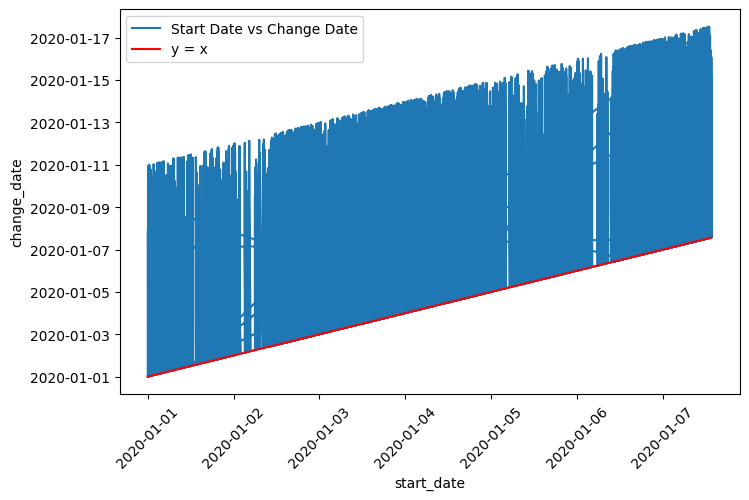

In [28]:
plt.figure(figsize=(8, 5))
plt.plot(df["start_date"], df["change_date"], label="Start Date vs Change Date")

# Draw y = x line in red
min_val = df["start_date"].min()
max_val = df["start_date"].max()
plt.plot([min_val, max_val], [min_val, max_val], "r-", label="y = x")

plt.xlabel("start_date")
plt.ylabel("change_date")
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [29]:
df[df["start_date"] > df["change_date"]]

,listing_id,transaction_type,item_type,item_subtype,start_date,change_date,price,area,site_area,floor,...,has_garden,city,zipcode,has_passenger_lift,is_new_construction,build_year,terrace_area,has_cellar,is_furnished,description_fr


#### 4.4 Deduplication
There are duplicate listings based on `listing_id`. The correct record should be the one with the most recent `change_date`. We sort by `change_date` descending and keep the first entry for each `listing_id`.


In [30]:
df[df.duplicated(keep=False)]

,listing_id,transaction_type,item_type,item_subtype,start_date,change_date,price,area,site_area,floor,...,has_garden,city,zipcode,has_passenger_lift,is_new_construction,build_year,terrace_area,has_cellar,is_furnished,description_fr


In [31]:
df[df.duplicated(subset=["listing_id"])]

,listing_id,transaction_type,item_type,item_subtype,start_date,change_date,price,area,site_area,floor,...,has_garden,city,zipcode,has_passenger_lift,is_new_construction,build_year,terrace_area,has_cellar,is_furnished,description_fr
8,154794185,TRANSACTION_TYPE.RENT,ITEM_TYPE.APARTMENT,ITEM_TYPE.APARTMENT.DUPLEX_OR_TRIPLEX,2020-01-01 00:03:00,2020-01-02 15:38:12,2315.0,158.50,NaN,5,...,<NA>,Cluses,74300,True,False,<NA>,NaN,True,False,"CLUSES - Dans copropriété de standing, superbe..."
9,154794185,TRANSACTION_TYPE.RENT,ITEM_TYPE.APARTMENT,ITEM_TYPE.APARTMENT.DUPLEX_OR_TRIPLEX,2020-01-01 00:03:00,2020-01-07 21:35:47,2315.0,158.50,NaN,5,...,<NA>,Cluses,74300,True,False,<NA>,NaN,True,False,"CLUSES - Dans copropriété de standing, superbe..."
16,154794197,TRANSACTION_TYPE.RENT,ITEM_TYPE.HOUSE,ITEM_TYPE.HOUSE.EXCEPTIONAL_PROPERTY,2020-01-01 00:05:00,2020-01-10 01:09:17,500.0,110.00,NaN,<NA>,...,<NA>,Pont-Trambouze,69240,<NA>,False,1900,NaN,True,False,Une maison de campagne dans petit hameau compo...
17,154794197,TRANSACTION_TYPE.RENT,ITEM_TYPE.HOUSE,ITEM_TYPE.HOUSE.EXCEPTIONAL_PROPERTY,2020-01-01 00:05:00,2020-01-05 04:18:57,500.0,110.00,NaN,<NA>,...,<NA>,Pont-Trambouze,69240,<NA>,False,1900,NaN,True,False,Une maison de campagne dans petit hameau compo...
20,154794213,TRANSACTION_TYPE.RENT,ITEM_TYPE.APARTMENT,ITEM_TYPE.APARTMENT.APARTMENT,2020-01-01 00:09:00,2020-01-08 17:48:11,350.0,27.27,NaN,2,...,<NA>,Vienne,38200,False,False,<NA>,NaN,False,False,"Coeur de Vienne, studio de 27.27 m² en parfait..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99991,189546125,TRANSACTION_TYPE.SELL,ITEM_TYPE.APARTMENT,ITEM_TYPE.APARTMENT.APARTMENT,2020-01-01 12:04:00,2020-01-11 09:29:09,340000.0,65.00,NaN,<NA>,...,<NA>,Colombes,92700,<NA>,False,<NA>,NaN,<NA>,<NA>,Colombes quartier Olympique à proximité de la ...
99992,189546125,TRANSACTION_TYPE.SELL,ITEM_TYPE.APARTMENT,ITEM_TYPE.APARTMENT.APARTMENT,2020-01-01 12:04:00,2020-01-06 10:30:43,340000.0,65.00,NaN,<NA>,...,<NA>,Colombes,92700,<NA>,False,<NA>,NaN,<NA>,<NA>,Colombes quartier Olympique à proximité de la ...
99994,190342585,TRANSACTION_TYPE.SELL,ITEM_TYPE.APARTMENT,ITEM_TYPE.APARTMENT.APARTMENT,2020-01-01 12:04:00,2020-01-08 02:46:04,225000.0,28.00,NaN,<NA>,...,<NA>,Colombes,92700,<NA>,False,<NA>,NaN,<NA>,<NA>,Colombes quartier Olympique proche de la gare ...
99996,190900607,TRANSACTION_TYPE.SELL,ITEM_TYPE.APARTMENT,ITEM_TYPE.APARTMENT.APARTMENT,2020-01-01 12:04:00,2020-01-11 00:42:56,265000.0,46.00,NaN,<NA>,...,<NA>,Colombes,92700,<NA>,False,<NA>,NaN,<NA>,<NA>,Colombes quartier Olympique à proximité de la ...


In [32]:
df[df.duplicated(subset=["listing_id", "start_date"])]

,listing_id,transaction_type,item_type,item_subtype,start_date,change_date,price,area,site_area,floor,...,has_garden,city,zipcode,has_passenger_lift,is_new_construction,build_year,terrace_area,has_cellar,is_furnished,description_fr
8,154794185,TRANSACTION_TYPE.RENT,ITEM_TYPE.APARTMENT,ITEM_TYPE.APARTMENT.DUPLEX_OR_TRIPLEX,2020-01-01 00:03:00,2020-01-02 15:38:12,2315.0,158.50,NaN,5,...,<NA>,Cluses,74300,True,False,<NA>,NaN,True,False,"CLUSES - Dans copropriété de standing, superbe..."
9,154794185,TRANSACTION_TYPE.RENT,ITEM_TYPE.APARTMENT,ITEM_TYPE.APARTMENT.DUPLEX_OR_TRIPLEX,2020-01-01 00:03:00,2020-01-07 21:35:47,2315.0,158.50,NaN,5,...,<NA>,Cluses,74300,True,False,<NA>,NaN,True,False,"CLUSES - Dans copropriété de standing, superbe..."
16,154794197,TRANSACTION_TYPE.RENT,ITEM_TYPE.HOUSE,ITEM_TYPE.HOUSE.EXCEPTIONAL_PROPERTY,2020-01-01 00:05:00,2020-01-10 01:09:17,500.0,110.00,NaN,<NA>,...,<NA>,Pont-Trambouze,69240,<NA>,False,1900,NaN,True,False,Une maison de campagne dans petit hameau compo...
17,154794197,TRANSACTION_TYPE.RENT,ITEM_TYPE.HOUSE,ITEM_TYPE.HOUSE.EXCEPTIONAL_PROPERTY,2020-01-01 00:05:00,2020-01-05 04:18:57,500.0,110.00,NaN,<NA>,...,<NA>,Pont-Trambouze,69240,<NA>,False,1900,NaN,True,False,Une maison de campagne dans petit hameau compo...
20,154794213,TRANSACTION_TYPE.RENT,ITEM_TYPE.APARTMENT,ITEM_TYPE.APARTMENT.APARTMENT,2020-01-01 00:09:00,2020-01-08 17:48:11,350.0,27.27,NaN,2,...,<NA>,Vienne,38200,False,False,<NA>,NaN,False,False,"Coeur de Vienne, studio de 27.27 m² en parfait..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99991,189546125,TRANSACTION_TYPE.SELL,ITEM_TYPE.APARTMENT,ITEM_TYPE.APARTMENT.APARTMENT,2020-01-01 12:04:00,2020-01-11 09:29:09,340000.0,65.00,NaN,<NA>,...,<NA>,Colombes,92700,<NA>,False,<NA>,NaN,<NA>,<NA>,Colombes quartier Olympique à proximité de la ...
99992,189546125,TRANSACTION_TYPE.SELL,ITEM_TYPE.APARTMENT,ITEM_TYPE.APARTMENT.APARTMENT,2020-01-01 12:04:00,2020-01-06 10:30:43,340000.0,65.00,NaN,<NA>,...,<NA>,Colombes,92700,<NA>,False,<NA>,NaN,<NA>,<NA>,Colombes quartier Olympique à proximité de la ...
99994,190342585,TRANSACTION_TYPE.SELL,ITEM_TYPE.APARTMENT,ITEM_TYPE.APARTMENT.APARTMENT,2020-01-01 12:04:00,2020-01-08 02:46:04,225000.0,28.00,NaN,<NA>,...,<NA>,Colombes,92700,<NA>,False,<NA>,NaN,<NA>,<NA>,Colombes quartier Olympique proche de la gare ...
99996,190900607,TRANSACTION_TYPE.SELL,ITEM_TYPE.APARTMENT,ITEM_TYPE.APARTMENT.APARTMENT,2020-01-01 12:04:00,2020-01-11 00:42:56,265000.0,46.00,NaN,<NA>,...,<NA>,Colombes,92700,<NA>,False,<NA>,NaN,<NA>,<NA>,Colombes quartier Olympique à proximité de la ...


In [33]:
df = df.sort_values(["listing_id", "change_date"], ascending=[True, False])
df = df.drop_duplicates(subset=["listing_id"], keep="first")
# df = df[df["build_year"] <= df["start_date"].dt.year]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 57004 entries, 0 to 99999
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   listing_id           57004 non-null  int64         
 1   transaction_type     57004 non-null  category      
 2   item_type            57004 non-null  category      
 3   item_subtype         56964 non-null  category      
 4   start_date           57004 non-null  datetime64[ns]
 5   change_date          57004 non-null  datetime64[ns]
 6   price                57004 non-null  float64       
 7   area                 56323 non-null  float64       
 8   site_area            31403 non-null  float64       
 9   floor                18231 non-null  Int64         
 10  room_count           56610 non-null  Int64         
 11  balcony_count        23119 non-null  Int64         
 12  terrace_count        16375 non-null  Int64         
 13  has_garden           62 non-null    

In [35]:
df.describe()

,listing_id,start_date,change_date,price,area,site_area,floor,room_count,balcony_count,terrace_count,build_year,terrace_area
count,5.700400e+04,57004,57004,5.700400e+04,56323.000000,3.140300e+04,18231.0,56610.0,23119.0,16375.0,16819.0,26.000000
mean,1.548981e+08,2020-01-04 10:55:55.768718080,2020-01-07 19:09:19.971229952,2.107351e+05,92.267873,1.174082e+03,2.783665,4.112754,0.36537,0.914748,1958.798085,30.919231
min,1.547942e+08,2020-01-01 00:00:00,2020-01-01 00:00:00,0.000000e+00,6.300000,9.200000e-01,-10.0,1.0,0.0,0.0,1.0,0.000000
25%,1.548357e+08,2020-01-02 21:02:00,2020-01-04 08:36:00,9.900000e+04,63.720001,4.000000e+02,1.0,3.0,0.0,0.0,1947.0,7.725000
50%,1.548828e+08,2020-01-04 03:22:00,2020-01-07 01:25:00,1.990000e+05,89.000000,5.600000e+02,2.0,4.0,0.0,1.0,1976.0,24.000000
75%,1.549301e+08,2020-01-06 14:48:15,2020-01-10 21:24:48.750000128,2.900000e+05,110.000000,9.000000e+02,3.0,5.0,1.0,1.0,2004.0,56.125001
max,1.909007e+08,2020-01-07 13:33:00,2020-01-17 12:33:23,4.750000e+06,20000.000000,1.150000e+06,11111.0,65.0,30.0,1260.0,2022.0,91.500000
std,6.720551e+05,NaN,NaN,1.751135e+05,102.784919,8.705810e+03,82.302752,1.793078,0.61313,10.062511,105.634701,26.652445


### 5. Missing Data Analysis
Visualize the proportion of missing values for each column.


`terrace_area` and `has_garden` have a significant number of missing values.


<Figure size 1000x600 with 0 Axes>

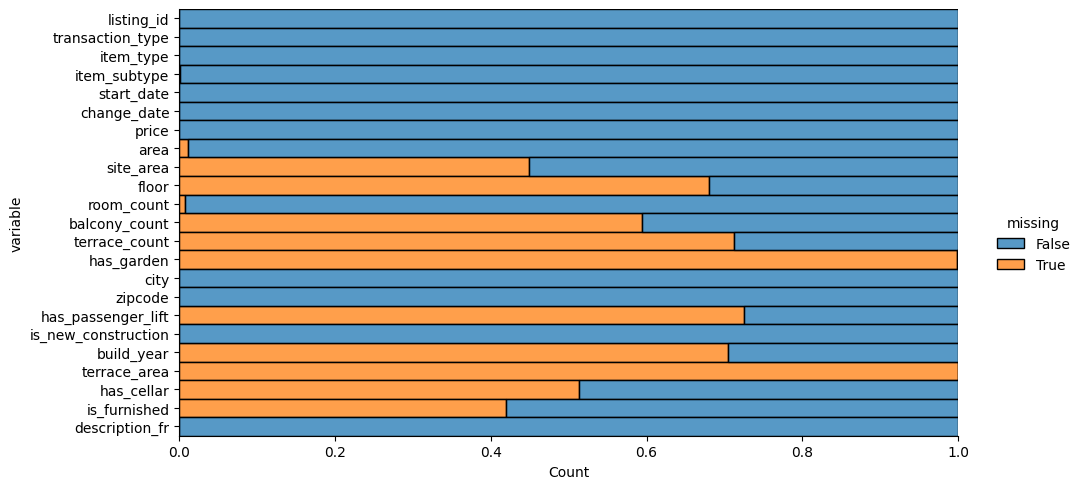

In [36]:
plt.figure(figsize=(10, 6))
fig1 = sns.displot(
    data=df.isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    aspect=2,
)

### 6. Categorical Data Analysis
Explore the distributions of key categorical features.


column 'transaction_type' with 2 levels
transaction_type
TRANSACTION_TYPE.SELL    45612
TRANSACTION_TYPE.RENT    11392
Name: count, dtype: int64


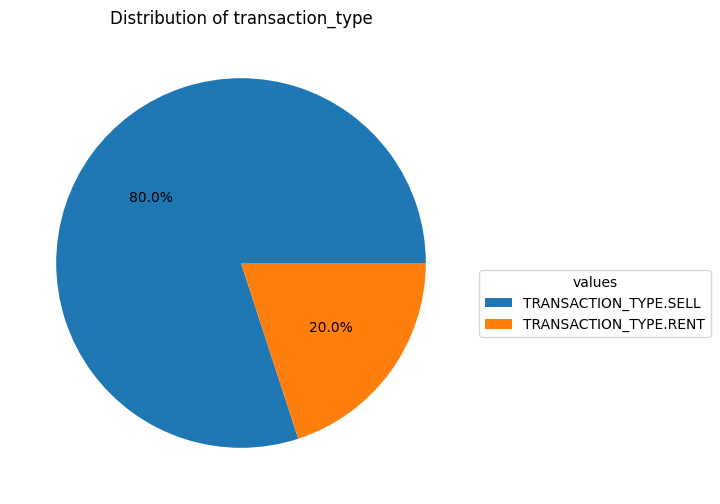

column 'item_type' with 8 levels
item_type
ITEM_TYPE.HOUSE                 34967
ITEM_TYPE.APARTMENT             21997
ITEM_TYPE.MISCELLANEOUS            32
ITEM_TYPE.STORAGE_PRODUCTION        3
ITEM_TYPE.PLOT                      2
ITEM_TYPE.OFFICE                    1
ITEM_TYPE.PARKING                   1
ITEM_TYPE.TRADING                   1
Name: count, dtype: int64


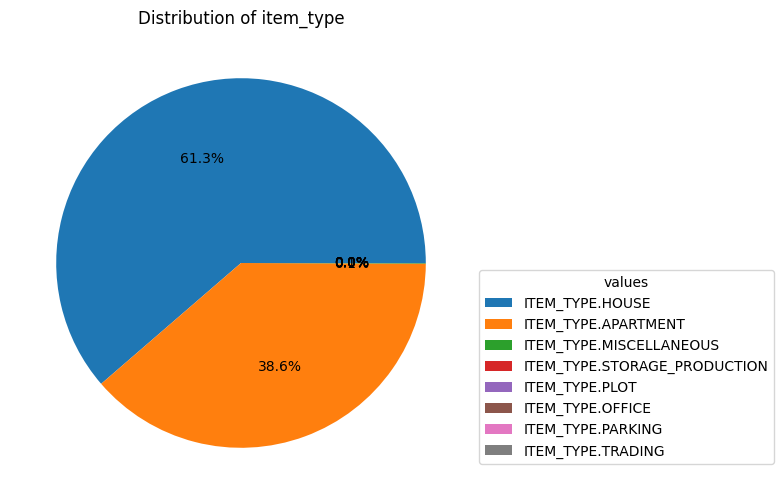

column 'item_subtype' with 11 levels
item_subtype
ITEM_TYPE.HOUSE.SINGLE_FAMILY_HOUSE      26954
ITEM_TYPE.APARTMENT.APARTMENT            20681
ITEM_TYPE.HOUSE.EXCEPTIONAL_PROPERTY      3424
ITEM_TYPE.HOUSE.VILLA                     3267
ITEM_TYPE.APARTMENT.DUPLEX_OR_TRIPLEX     1316
ITEM_TYPE.HOUSE.TOWN_HOUSE                 842
ITEM_TYPE.HOUSE.FARMHOUSE                  281
ITEM_TYPE.HOUSE.MANOR                       76
ITEM_TYPE.HOUSE.CHALET                      54
ITEM_TYPE.HOUSE.SEMIDETACHED_HOUSE          50
ITEM_TYPE.HOUSE.GITE                        19
Name: count, dtype: int64


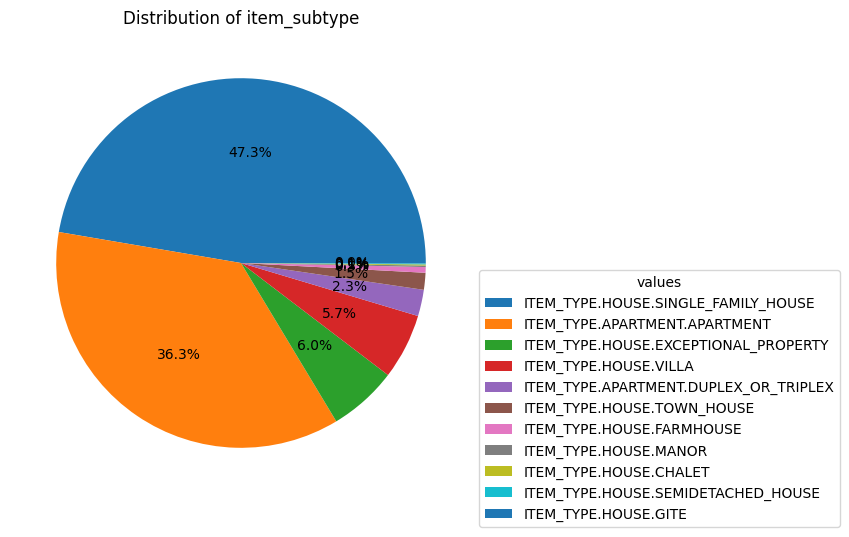

column 'city' with 10436 levels
city
Toulouse               670
Bordeaux               409
Montpellier            380
Nice                   353
Paris 15ème            232
                      ... 
La Loupe 5km             1
Thiron Gardais           1
Remalard 8km             1
Belleme 10km             1
Longny les Villages      1
Name: count, Length: 10436, dtype: Int64
column 'zipcode' with 4508 levels
zipcode
30000    294
34230    252
33000    240
34000    239
75015    232
        ... 
02490      1
23230      1
62143      1
89130      1
50220      1
Name: count, Length: 4508, dtype: Int64


In [37]:
cat_cols = [
    "transaction_type",
    "item_type",
    "item_subtype",
    "city",
    "zipcode",
]
for col in cat_cols:
    counts = df[col].value_counts()
    print(f"column '{col}' with {len(counts)} levels")
    print(counts)
    if len(counts) < 20:
        ax = counts.plot.pie(
            autopct="%1.1f%%", figsize=(6, 6), labels=[""] * len(counts)
        )
        plt.legend(ax.patches, counts.index, title="values", bbox_to_anchor=(1, 0.5))
        plt.ylabel("")
        plt.title(f"Distribution of {col}")
        plt.show()

`item_type` and `item_subtype` hierarchical prefixes make sense, the first part of `item_subtype` is the item type.

In [38]:
df[df["item_type"] != df["item_subtype"].str.split(".").str[:-1].str.join(".")].dropna(
    subset=["item_subtype"]
)

,listing_id,transaction_type,item_type,item_subtype,start_date,change_date,price,area,site_area,floor,...,has_garden,city,zipcode,has_passenger_lift,is_new_construction,build_year,terrace_area,has_cellar,is_furnished,description_fr


column 'has_garden' with 2 levels
has_garden
False    55
True      7
Name: count, dtype: Int64


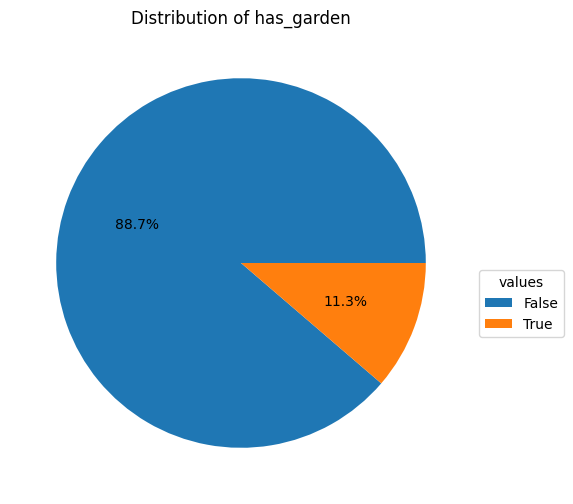

column 'has_passenger_lift' with 2 levels
has_passenger_lift
True     9428
False    6220
Name: count, dtype: Int64


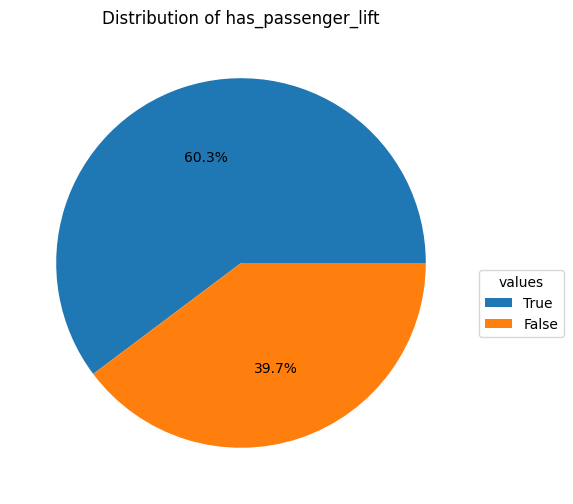

column 'is_new_construction' with 1 levels
is_new_construction
False    57004
Name: count, dtype: Int64


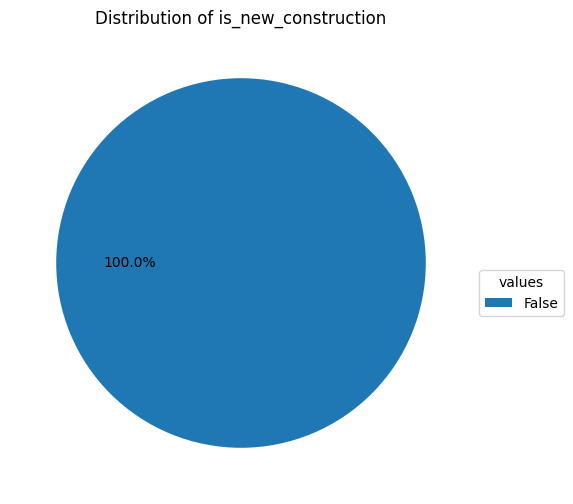

column 'has_cellar' with 2 levels
has_cellar
False    17602
True     10167
Name: count, dtype: Int64


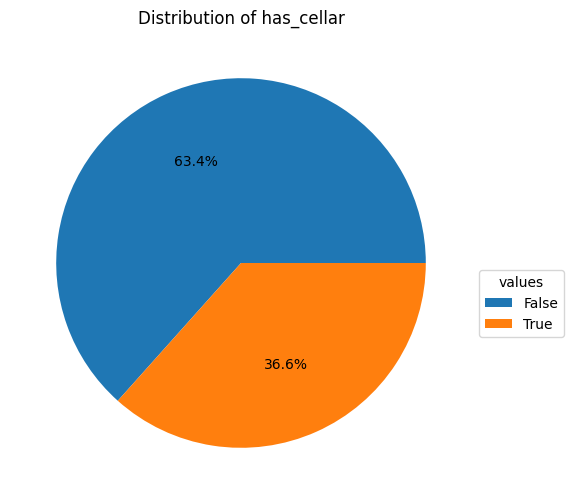

column 'is_furnished' with 2 levels
is_furnished
False    30160
True      2925
Name: count, dtype: Int64


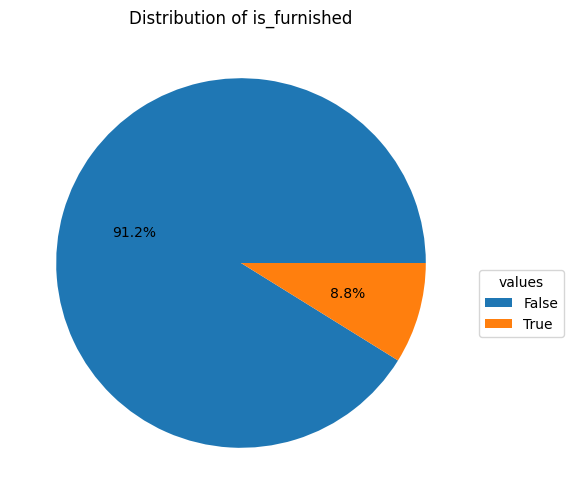

In [40]:
for col in bool_cols:
    counts = df[col].value_counts()
    print(f"column '{col}' with {len(counts)} levels")
    print(counts)
    if len(counts) < 20:
        ax = counts.plot.pie(
            autopct="%1.1f%%", figsize=(6, 6), labels=[""] * len(counts)
        )
        plt.legend(ax.patches, counts.index, title="values", bbox_to_anchor=(1, 0.5))
        plt.ylabel("")
        plt.title(f"Distribution of {col}")
        plt.show()

The distribution gives insight about indexing strategy (partial index for rare values, no index when there is only one value ...)

In [41]:
df[df["zipcode"] == "34230"]["city"].unique()

<StringArray>
['Saint-Pons-de-Mauchiens',                'Plaissan',
                 'Paulhan',               'Vendémian',
          'Saint-Pargoire',               'Le Pouget',
                 'Pouzols',                 'Adissan',
               'Vendemian',        'Usclas d'Herault',
          'Saint Pargoire',               'Puilacher',
               'Campagnan']
Length: 13, dtype: string

zipcode does not identify a unique city, so we don't have functional dependency `zipcode` -> `city` (normalisation considerations) 

### 7. Numerical Data Analysis
Explore the distributions of numerical features to identify outliers and understand their spread.


In [42]:
df.describe()

,listing_id,start_date,change_date,price,area,site_area,floor,room_count,balcony_count,terrace_count,build_year,terrace_area
count,5.700400e+04,57004,57004,5.700400e+04,56323.000000,3.140300e+04,18231.0,56610.0,23119.0,16375.0,16819.0,26.000000
mean,1.548981e+08,2020-01-04 10:55:55.768718080,2020-01-07 19:09:19.971229952,2.107351e+05,92.267873,1.174082e+03,2.783665,4.112754,0.36537,0.914748,1958.798085,30.919231
min,1.547942e+08,2020-01-01 00:00:00,2020-01-01 00:00:00,0.000000e+00,6.300000,9.200000e-01,-10.0,1.0,0.0,0.0,1.0,0.000000
25%,1.548357e+08,2020-01-02 21:02:00,2020-01-04 08:36:00,9.900000e+04,63.720001,4.000000e+02,1.0,3.0,0.0,0.0,1947.0,7.725000
50%,1.548828e+08,2020-01-04 03:22:00,2020-01-07 01:25:00,1.990000e+05,89.000000,5.600000e+02,2.0,4.0,0.0,1.0,1976.0,24.000000
75%,1.549301e+08,2020-01-06 14:48:15,2020-01-10 21:24:48.750000128,2.900000e+05,110.000000,9.000000e+02,3.0,5.0,1.0,1.0,2004.0,56.125001
max,1.909007e+08,2020-01-07 13:33:00,2020-01-17 12:33:23,4.750000e+06,20000.000000,1.150000e+06,11111.0,65.0,30.0,1260.0,2022.0,91.500000
std,6.720551e+05,NaN,NaN,1.751135e+05,102.784919,8.705810e+03,82.302752,1.793078,0.61313,10.062511,105.634701,26.652445


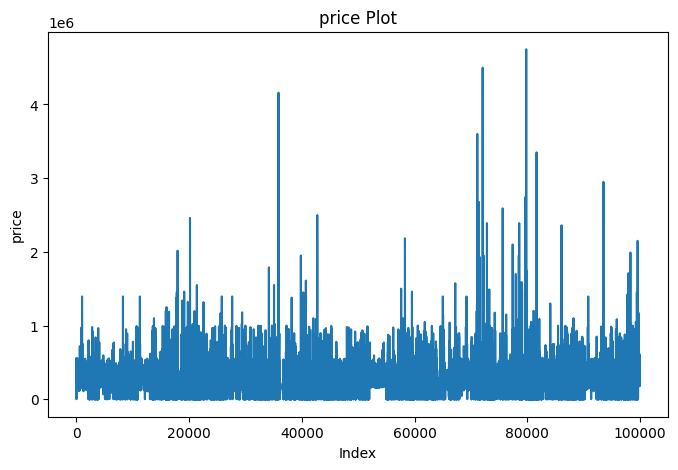

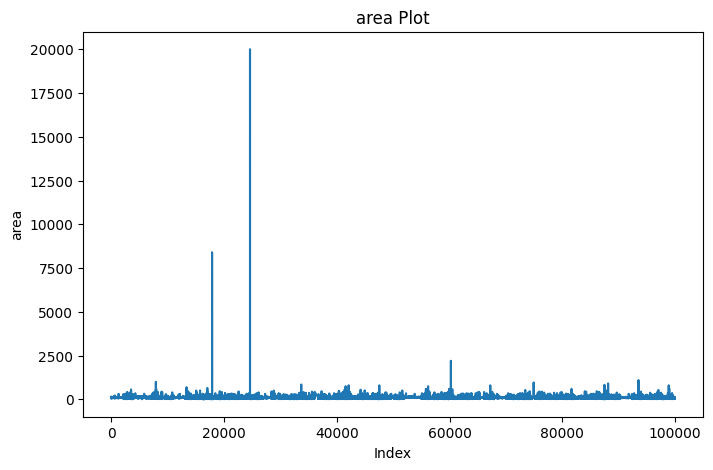

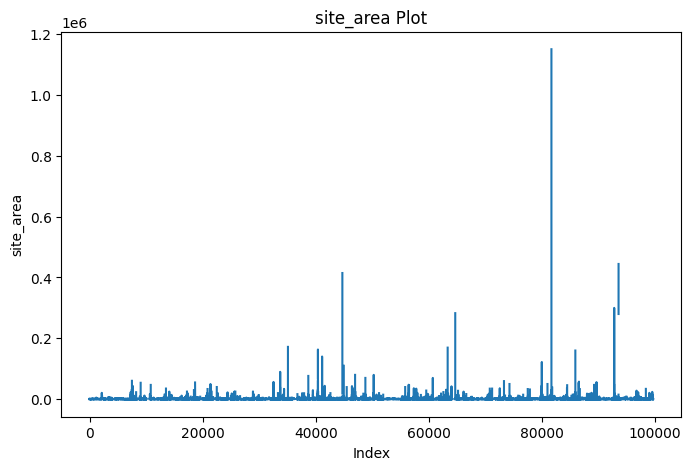

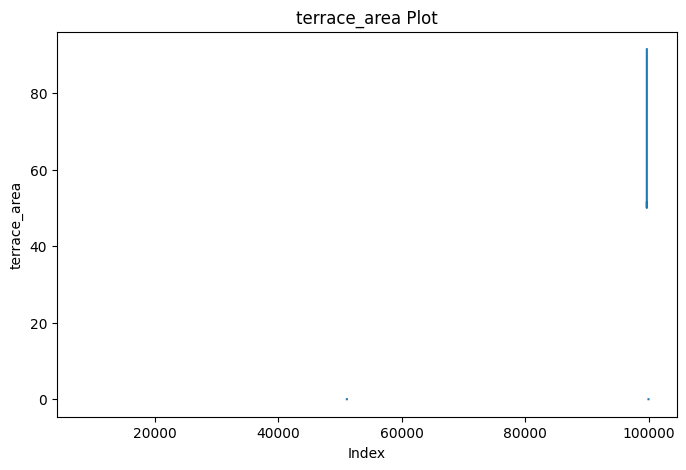

In [43]:
float_cols = ["price", "area", "site_area", "terrace_area"]
for col in float_cols:
    plt.figure(figsize=(8, 5))
    plt.plot(df[col])
    plt.xlabel("Index")
    plt.ylabel(col)
    plt.title(f"{col} Plot")
    plt.show()

#### 7.1 Outlier Detection
Use boxplots and Z-scores to identify potential outliers in numerical columns.


floor
1        4698
2        3751
0        3486
3        2767
4        1565
5         835
6         521
7         251
8         104
9          72
10         53
11         31
12         18
13         14
15         14
16         13
14         11
25          4
17          4
-1          4
21          2
22          2
28          2
56          1
-3          1
20          1
19          1
26          1
11111       1
30          1
54          1
-10         1
Name: count, dtype: Int64


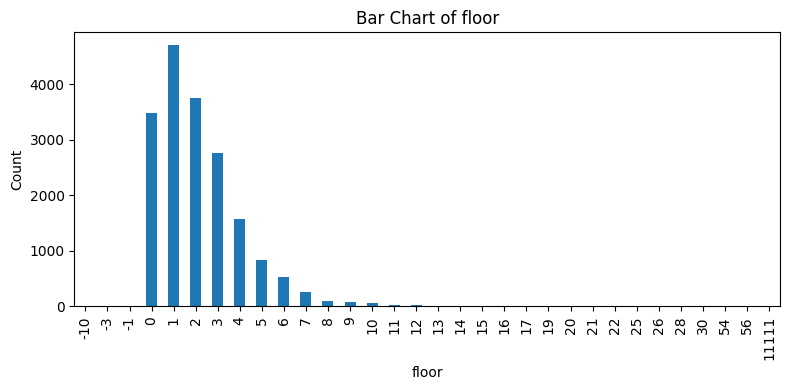

room_count
5     13797
4     13075
3      9012
2      7164
6      6420
1      3639
7      2003
8       734
9       326
10      221
11       70
12       63
13       22
14       17
15       14
20        9
18        6
16        6
17        5
19        2
23        2
50        2
65        1
Name: count, dtype: Int64


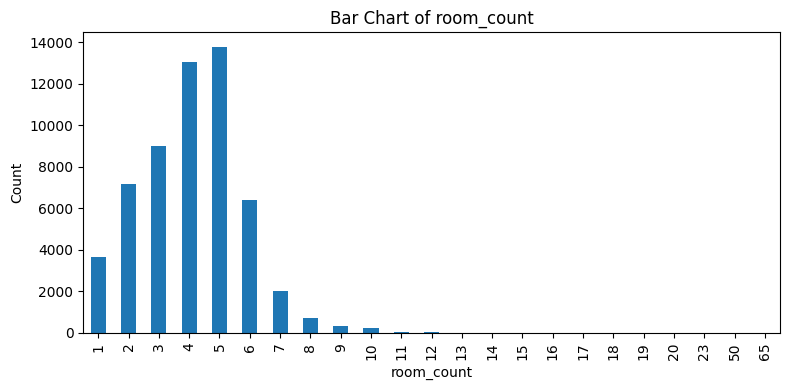

balcony_count
0     15442
1      7095
2       504
3        57
4         6
8         4
5         4
10        2
14        1
30        1
15        1
12        1
6         1
Name: count, dtype: Int64


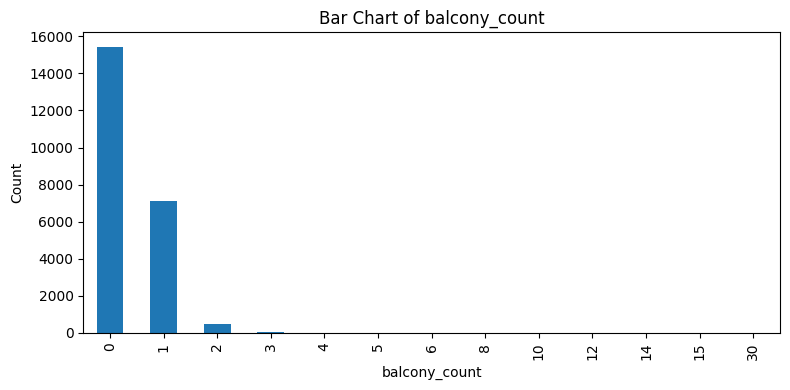

terrace_count
1       10669
0        4937
2         603
3          93
4          10
9           4
6           4
30          4
16          4
20          4
7           3
11          3
10          3
100         3
12          3
22          2
14          2
25          2
8           2
24          2
15          2
19          2
26          1
35          1
45          1
23          1
80          1
70          1
40          1
21          1
1260        1
60          1
27          1
18          1
17          1
65          1
Name: count, dtype: Int64


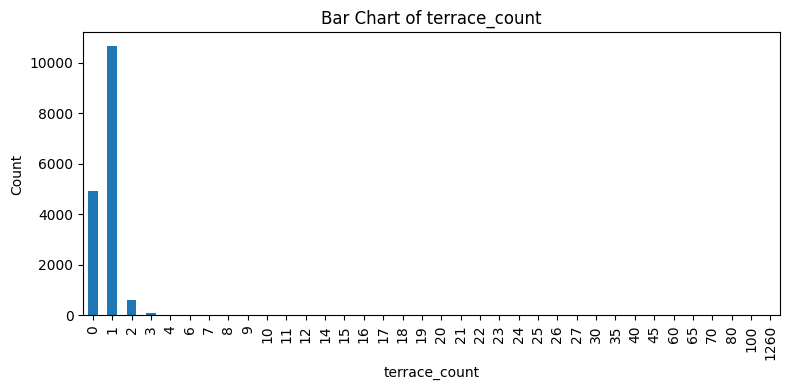

build_year
1900    1537
1970    1000
1930     587
1980     555
2019     538
        ... 
1520       1
1350       1
1250       1
1852       1
1749       1
Name: count, Length: 273, dtype: Int64


<Figure size 800x400 with 0 Axes>

In [44]:
for col in int_cols:
    plt.figure(figsize=(8, 4))
    counts = df[col].value_counts()
    print(counts)
    if len(counts) < 100:
        counts.sort_index().plot.bar()
        plt.title(f"Bar Chart of {col}")
        plt.xlabel(col)
        plt.ylabel("Count")
        plt.tight_layout()
        plt.show()

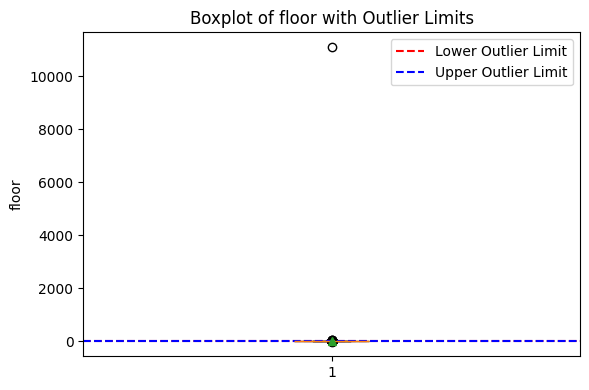

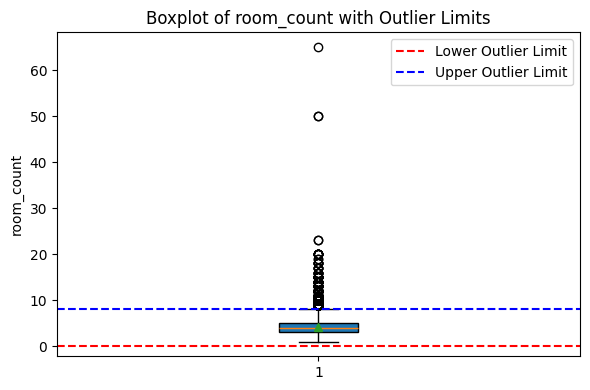

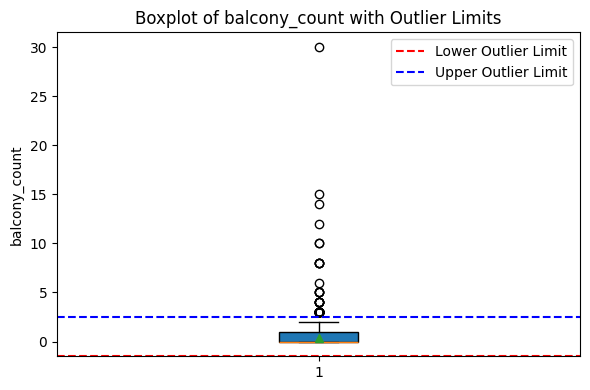

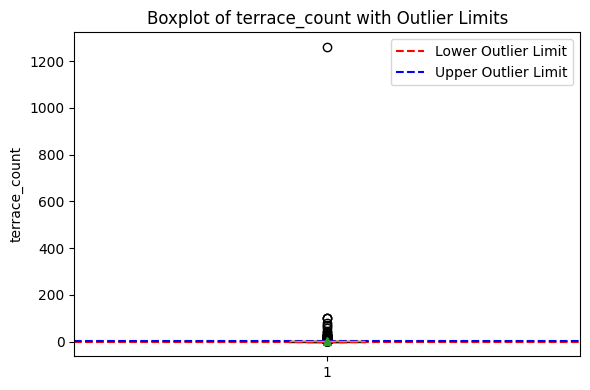

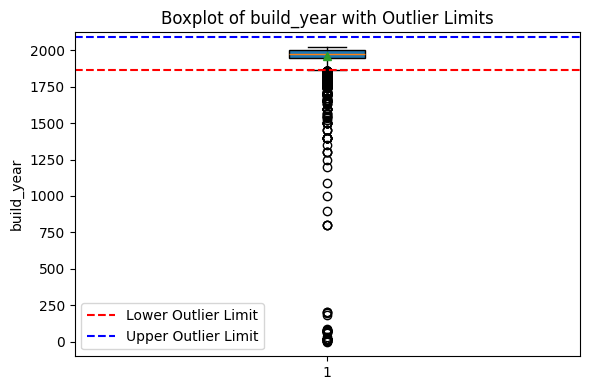

In [45]:
for col in int_cols:
    data = df[col].dropna()
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1
    lower_limit = q1 - 1.5 * iqr
    upper_limit = q3 + 1.5 * iqr

    plt.figure(figsize=(6, 4))
    plt.boxplot(data, vert=True, patch_artist=True, showmeans=True)
    plt.title(f"Boxplot of {col} with Outlier Limits")
    plt.ylabel(col)

    # Show outlier limits as horizontal lines
    plt.axhline(lower_limit, color="red", linestyle="--", label="Lower Outlier Limit")
    plt.axhline(upper_limit, color="blue", linestyle="--", label="Upper Outlier Limit")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [46]:
df[["listing_id"] + int_cols].dropna()[
    (
        np.abs(
            stats.zscore(
                df[int_cols].dropna().astype({col: "int64" for col in int_cols})
            )
        )
        >= 3
    ).any(axis=1)
]

,listing_id,floor,room_count,balcony_count,terrace_count,build_year
2668,154799357,0,5,14,0,2020
7793,154806303,2,2,15,0,2002
19809,154827401,1,1,0,0,1700
19971,154827691,4,7,0,0,1898
20620,154828835,8,4,0,1,1970
20970,154829601,9,3,1,0,1974
21501,154830445,1,3,0,1,19
21715,154830793,0,7,1,1,1990
22755,154832459,0,2,0,0,1690
24433,154834937,4,3,0,0,1400


In [47]:
for col in int_cols:
    print(col)
    print(df[["listing_id", col]].dropna()[np.abs(stats.zscore(df[col].dropna())) >= 3])

floor
       listing_id  floor
41887   154864543  11111
room_count
       listing_id  room_count
2149    154798353          10
2153    154798363          10
2154    154798365          11
2203    154798465          10
2653    154799339          10
...           ...         ...
98986   154971245          16
98989   154971253          10
99481   154971961          15
99485   154971969          11
99497   154971993          10

[440 rows x 2 columns]
balcony_count
       listing_id  balcony_count
2668    154799357             14
3646    154800621              3
7793    154806303             15
8917    154808675              3
10040   154810293              3
...           ...            ...
96750   154967001              8
96752   154967005              6
96762   154967013             10
99678   155021663              3
99693   155027267              3

[78 rows x 2 columns]
terrace_count
       listing_id  terrace_count
19918   154827603             35
24440   154834945             45
580

In [48]:
df[["listing_id"] + [col for col in float_cols if col != "terrace_area"]].dropna()[
    (
        np.abs(
            stats.zscore(
                df[[col for col in float_cols if col != "terrace_area"]].dropna()
            )
        )
        >= 3
    ).any(axis=1)
]

,listing_id,price,area,site_area
615,154794971,720000.0,220.0,1868.0
923,154795499,976630.0,90.0,1680.0
1015,154795591,1394630.0,90.0,917.0
1123,154795705,749630.0,90.0,859.0
1291,154796345,140462.0,315.0,315.0
...,...,...,...,...
98982,154971237,490000.0,600.0,2850.0
98986,154971245,393750.0,620.0,9250.0
99338,154971721,988000.0,152.0,231.0
99481,154971961,204500.0,360.0,2811.0


In [49]:
for col in float_cols:
    print(col)
    print(df[["listing_id", col]].dropna()[np.abs(stats.zscore(df[col].dropna())) >= 3])

price
       listing_id      price
923     154795499   976630.0
1015    154795591  1394630.0
1123    154795705   749630.0
2160    154798379   740000.0
2166    154798399   798400.0
...           ...        ...
99663   154984497   780000.0
99672   155020393   775000.0
99675   155020733  1165000.0
99699   155027323  1180000.0
99720   155028017   946500.0

[771 rows x 2 columns]
area
       listing_id    area
2824    154799717   420.0
3503    154800425   563.0
7853    154806377   490.0
7898    154806517  1000.0
7960    154806627   600.0
...           ...     ...
96891   154967271   409.0
97051   154967693   536.0
98886   154971015   800.0
98982   154971237   600.0
98986   154971245   620.0

[77 rows x 2 columns]
site_area
       listing_id  site_area
2826    154799725    50000.0
7472    154805407    32449.0
7486    154805447    60500.0
7658    154805985    43219.0
9028    154808895    54013.0
...           ...        ...
92753   154960529    30000.0
93521   154961785   280000.0
93522   154

### 8. Prepare Item Category Table
Since `item_subtype` -> `item_type`, in order to get the relation to the 3rd normal form, we should move them into a new relation.

Create a separate table for `item_category` that maps `item_subtype` to `item_type`.
It is more practical to remove the hierarchical prefixes (remove redundancy)

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 57004 entries, 0 to 99999
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   listing_id           57004 non-null  int64         
 1   transaction_type     57004 non-null  category      
 2   item_type            57004 non-null  category      
 3   item_subtype         56964 non-null  category      
 4   start_date           57004 non-null  datetime64[ns]
 5   change_date          57004 non-null  datetime64[ns]
 6   price                57004 non-null  float64       
 7   area                 56323 non-null  float64       
 8   site_area            31403 non-null  float64       
 9   floor                18231 non-null  Int64         
 10  room_count           56610 non-null  Int64         
 11  balcony_count        23119 non-null  Int64         
 12  terrace_count        16375 non-null  Int64         
 13  has_garden           62 non-null    

In [51]:
df_item_category = df[["item_subtype", "item_type"]].astype(str)

In [52]:
df_item_category["item_type"][df_item_category["item_subtype"] == "nan"].value_counts()

item_type
ITEM_TYPE.MISCELLANEOUS         32
ITEM_TYPE.STORAGE_PRODUCTION     3
ITEM_TYPE.PLOT                   2
ITEM_TYPE.TRADING                1
ITEM_TYPE.PARKING                1
ITEM_TYPE.OFFICE                 1
Name: count, dtype: int64

In [53]:
df_item_category.loc[df_item_category["item_subtype"] == "nan", "item_subtype"] = (
    df_item_category["item_type"]
)

In [54]:
df_item_category = df_item_category.drop_duplicates(subset=["item_subtype"])[
    ["item_type", "item_subtype"]
]
df_item_category

,item_type,item_subtype
0,ITEM_TYPE.HOUSE,ITEM_TYPE.HOUSE.SINGLE_FAMILY_HOUSE
1,ITEM_TYPE.HOUSE,ITEM_TYPE.HOUSE.TOWN_HOUSE
3,ITEM_TYPE.HOUSE,ITEM_TYPE.HOUSE.EXCEPTIONAL_PROPERTY
9,ITEM_TYPE.APARTMENT,ITEM_TYPE.APARTMENT.DUPLEX_OR_TRIPLEX
14,ITEM_TYPE.APARTMENT,ITEM_TYPE.APARTMENT.APARTMENT
2150,ITEM_TYPE.HOUSE,ITEM_TYPE.HOUSE.VILLA
2824,ITEM_TYPE.HOUSE,ITEM_TYPE.HOUSE.MANOR
3805,ITEM_TYPE.HOUSE,ITEM_TYPE.HOUSE.CHALET
5267,ITEM_TYPE.HOUSE,ITEM_TYPE.HOUSE.FARMHOUSE
7287,ITEM_TYPE.HOUSE,ITEM_TYPE.HOUSE.SEMIDETACHED_HOUSE


In [55]:
df_item_category.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17 entries, 0 to 73493
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   item_type     17 non-null     object
 1   item_subtype  17 non-null     object
dtypes: object(2)
memory usage: 408.0+ bytes
